This notebook represents a prototypical python 3 implementation for a without safeguards, without asserts, with fixed paramterized model. For larger data sets it is advised to store intermediate results, e.g. as pickle files.

Theory https://towardsdatascience.com/effortlessly-recommending-similar-images-b65aff6aabfb



# Rescaling

We assume to have a folder "originalImages" in the working directory. It shall contain jpg images.
As we will employ resnet18 using PyTorch, we need to resize the images to normalized 224x224 images
In a first step they are resized and stored in a different folder inputImagesCNN

In [1]:
# Import các thư viện cần thiết
import os
from PIL import Image
from torchvision import transforms 

# Kích thước cần thiết cho CNN
inputDim = (224,224)
# Thư mục chứa ảnh gốc
inputDir = "originalImages"
# Thư mục chứa ảnh đã được chuyển đổi
inputDirCNN = "scaled"

# Tạo thư mục chứa ảnh đã được chuyển đổi nếu chưa tồn tại
os.makedirs(inputDirCNN, exist_ok = True)

# Chuẩn bị quy trình chuyển đổi ảnh
transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

# Duyệt qua tất cả ảnh trong thư mục gốc
for imageName in os.listdir(inputDir):    
    # Mở ảnh
    img = Image.open(os.path.join(inputDir, imageName))
    # Chuyển đổi ảnh theo quy trình đã chuẩn bị
    newImg = transformationForCNNInput(img)

    # Sao chép thông tin xoay ảnh từ ảnh gốc và lưu, nếu không ảnh chuyển đổi có thể bị xoay
    if('exif' in img.info):
        exif = img.info['exif']
        newImg.save(os.path.join(inputDirCNN, imageName), exif=exif)
    else:
        newImg.save(os.path.join(inputDirCNN, imageName))
    
    # Đóng ảnh
    newImg.close()
    img.close()

# Creating the similarity matrix with Resnet18

Let us first calculate the feature vectors with resnet18 on a CPU. The input is normalized to the ImageNet mean values/standard deviation.

In [2]:
import torch
from tqdm import tqdm
from torchvision import models

# for this prototype we use no gpu, cuda= False and as model resnet18 to obtain feature vectors

class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        
        return cnnModel, layer
        

# generate vectors for all the images in the set
img2vec = Img2VecResnet18() 

allVectors = {}
print("Converting images to feature vectors:")
for image in tqdm(os.listdir("scaled")):
    img = Image.open(os.path.join("scaled", image))
    # Convert image to RGB if it's not already in RGB
    if img.mode != 'RGB':
        img = img.convert('RGB')
    vec = img2vec.getVec(img)
    allVectors[image] = vec
    img.close() 

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Converting images to feature vectors:


100%|██████████| 92/92 [00:06<00:00, 15.20it/s]


# Cosine similarity
Calculate for all vectors the cosine similarity to the other vectors.
Note that this matrix may become huge, hence infefficient, with many thousands of images

In [3]:
# now let us define a function that calculates the cosine similarity entries in the similarity matrix
import pandas as pd
import numpy as np

def getSimilarityMatrix(vectors):
    v = np.array(list(vectors.values())).T
    sim = np.inner(v.T, v.T) / ((np.linalg.norm(v, axis=0).reshape(-1,1)) * ((np.linalg.norm(v, axis=0).reshape(-1,1)).T))
    keys = list(vectors.keys())
    matrix = pd.DataFrame(sim, columns = keys, index = keys)
    
    return matrix
        
similarityMatrix = getSimilarityMatrix(allVectors)

# Prepare top-k lists
Now that the similarity matrix is fully available, the last step is to sort the values per item and store the top similar entries in another data structure

In [4]:
from numpy.testing import assert_almost_equal
import pickle

k = 5 # the number of top similar images to be stored

similarNames = pd.DataFrame(index = similarityMatrix.index, columns = range(k))
similarValues = pd.DataFrame(index = similarityMatrix.index, columns = range(k))

for j in tqdm(range(similarityMatrix.shape[0])):
    kSimilar = similarityMatrix.iloc[j, :].sort_values(ascending = False).head(k)
    similarNames.iloc[j, :] = list(kSimilar.index)
    similarValues.iloc[j, :] = kSimilar.values
    
similarNames.to_pickle("similarNames.pkl")
similarValues.to_pickle("similarValues.pkl")

100%|██████████| 92/92 [00:00<00:00, 3013.97it/s]


# Get and visualize similar images for four example inputs

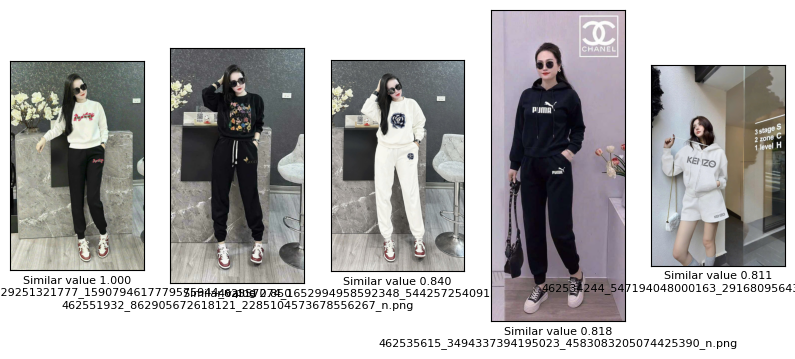

In [5]:
import matplotlib.pyplot as plt
    
# take three examples from the provided image set and plot
inputImages = ["462551404_8354429251321777_1590794617779575944_n.png"]

numCol = 5
numRow = 1

def setAxes(ax, image, query = False, **kwargs):
    fontsize = 8
    value = kwargs.get("value", None)
    if query:
        ax.set_xlabel("Input\n{0}".format(image), fontsize = fontsize)
    else:
        ax.set_xlabel("Similar value {1:1.3f}\n{0}".format( image,  value), fontsize = fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    
def FindSimilarImages(imgPath):
    if imgPath in set(similarNames.index):
        imgPaths = list(similarNames.loc[imgPath, :])
        vals = list(similarValues.loc[imgPath, :])

        if imgPath in imgPaths:
            assert_almost_equal(max(vals), 1, decimal = 5)
            imgPaths.remove(imgPath)
            vals.remove(max(vals))

        return imgPaths, vals
    else:
        print("'{}' Unknown image".format(imgPath))
        
def plotSimilarImages(imgPath):
    foundImgPaths, foundValues = FindSimilarImages(imgPath)
    fig = plt.figure(figsize=(10, 20))
    
    # Thêm ảnh tìm kiếm vào danh sách ảnh giống
    imgPaths = [imgPath] + foundImgPaths
    vals = [1] + foundValues  # Giá trị tương tự cho ảnh tìm kiếm là 1
    # now plot the  most simliar images
    for j in range(0, numCol*numRow):
        ax = []
        img = Image.open(os.path.join(inputDir, imgPaths[j]))
        ax.append(fig.add_subplot(numRow, numCol, j+1))
        setAxes(ax[-1], imgPaths[j], value = vals[j])
        img = img.convert('RGB')
        plt.imshow(img)
        img.close()
    
    
    plt.show()
        
for imgPath in inputImages:
    plotSimilarImages(imgPath)